In [15]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

#### Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. It contains a set of 25,000 highly polar movie reviews for training, and 25,000 for testing

In [2]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Asus\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteRKD585\imdb_reviews-train.…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Asus\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteRKD585\imdb_reviews-test.t…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Asus\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteRKD585\imdb_reviews-unsupe…

Dataset imdb_reviews downloaded and prepared to C:\Users\Asus\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/subwords8k/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Uses `tfds.deprecated.text.SubwordTextEncoder` with 8k vocab size
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='C:\\Users\\Asus\\tensorflow_datasets\\imdb_reviews\\subwords8k\\1.0.0',
    download_size=80.23 MiB,
    dataset_size=54.72 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    supervised_keys=('text', 'label'),
    disable_shuff

In [4]:
train_examples_batch, train_labels_batch = next(iter(train_dataset))
print(train_examples_batch)
print(train_labels_batch)

tf.Tensor(
[  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975], shape=(163,), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


### Text Encoding
The dataset info includes the encoder (a tfds.features.text.SubwordTextEncoder). This text encoder will reversibly encode any string, falling back to byte-encoding if necessary

In [5]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [7]:
sample_string = 'Hello Aditya! Nice Weather!'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 1620, 828, 8026, 90, 4409, 49, 1231, 6684, 8043, 7962]
The original string: "Hello Aditya! Nice Weather!"


In [9]:
assert original_string == sample_string
for index in encoded_string:
  print('{} is decoded to {}'.format(index, encoder.decode([index])))

4025 is decoded to Hell
222 is decoded to o 
1620 is decoded to Ad
828 is decoded to ity
8026 is decoded to a
90 is decoded to ! 
4409 is decoded to Nic
49 is decoded to e 
1231 is decoded to We
6684 is decoded to athe
8043 is decoded to r
7962 is decoded to !


In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

### Model using Sequential

Creating a tf.keras.Sequential model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies. Keras sequential model here since all the layers in the model only have single input and produce single output.

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), we'll use the binary_crossentropy loss function. It is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

In [12]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

Train the model for 10 epochs. This is 10 iterations over all samples in the train_dataset tensors.

In [13]:
history = model.fit(train_dataset, epochs = 10, validation_data = test_dataset, validation_steps = 30)

Epoch 1/10
391/391 [==============================] - 1379s 4s/step - loss: 0.6851 - accuracy: 0.5119 - val_loss: 0.5818 - val_accuracy: 0.7130
Epoch 2/10
391/391 [==============================] - 1394s 4s/step - loss: 0.3788 - accuracy: 0.8378 - val_loss: 0.3511 - val_accuracy: 0.8703
Epoch 3/10
391/391 [==============================] - 1286s 3s/step - loss: 0.2722 - accuracy: 0.8972 - val_loss: 0.3346 - val_accuracy: 0.8672
Epoch 4/10
391/391 [==============================] - 1303s 3s/step - loss: 0.2081 - accuracy: 0.9300 - val_loss: 0.3660 - val_accuracy: 0.8693
Epoch 5/10
391/391 [==============================] - 1342s 3s/step - loss: 0.1762 - accuracy: 0.9426 - val_loss: 0.3741 - val_accuracy: 0.8682
Epoch 6/10
391/391 [==============================] - 1296s 3s/step - loss: 0.1489 - accuracy: 0.9532 - val_loss: 0.4242 - val_accuracy: 0.8635
Epoch 7/10
391/391 [==============================] - 1380s 4s/step - loss: 0.1359 - accuracy: 0.9589 - val_loss: 0.4026 - val_accuracy:

### Accuracy of the Model on Test Data

In [14]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 261s 669ms/step - loss: 0.5185 - accuracy: 0.8475
Test Loss: 0.5184891223907471
Test Accuracy: 0.8474799990653992


### Accuracy vs Epochs

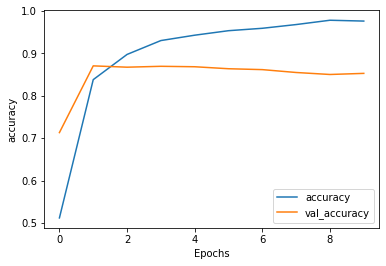

In [16]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

plot_graphs(history, 'accuracy')

### Loss vs Epochs

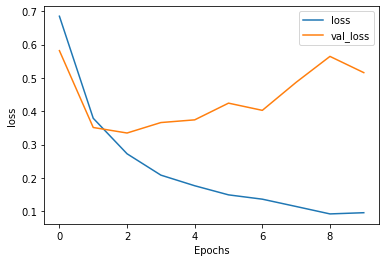

In [17]:
plot_graphs(history, 'loss')

### Prediction Functions

In [18]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [19]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  print("Prediction Score: ", predictions)
  output = ""
  if predictions[0][0] >= 0.5: output = "POSITIVE"
  elif predictions[0][0] <= -1: output = "NEGATIVE"
  else: output = "NEUTRAL"

  return output

### Prediction with Sample Sentiments

In [20]:
sample_pred_text = ('This movie was so so. The acting was medicore. Kind of recommend')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[0.10418288]]
NEUTRAL


In [21]:
sample_pred_text = ("""After we screened August To June, Boynton, Boca Democratic Party Movie Night presenters said in all their years of doing this had 
they never seen an audience response so serene. People wanted to stay. No one was angry. Conversations that never occurred did so after this viewing. People 
who had known each other for years discovered commonalities that previously they did not know existed. When this was shared I asked for any theories. 
The response, in unison, August To June is warm.  It touches people. Real life school situations gave the audience hope not only for what could be, but 
already is. People were reminded of good times and the challenges that helped them grow greater. As a Teacher, Amy taught as I think wise to live. Reciprocal 
reverence.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[4.416259]]
POSITIVE


In [22]:
sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)


Prediction Score:  [[-2.747773]]
NEGATIVE


In [23]:
sample_pred_text = ("""Overrated Sequel, But Still Good, But Violent! Beloved characters die, a character gets their head cut off, someone falls off a cliff, 
stabbings, punching, shooting, and more. The characters swear a bit. Even Captain America does! Role models include, Captain America, Iron Man, Hulk, AntMan, 
Black Widow, Hawkeye. Thor not so much because he SPOILER ALERT: got fat and played Fortnite the entire 5 year period. He was funny, but you may not want your 
kid wanting to say 'I want to be like the God of Thunder and play fortnite all day'. Characters did kiss. Thor drank a lot of beer. Captain America proved 
himself of something but not saying what. With reviewing the movie, the first half hour was good, then the next half hour was slow. The second half hour was 
pretty good, but the last hour was epic. From just starting out with Iron Man, Cap, Thor, and Hulk, to this amazing fight scene at the end, Avengers Endgame 
really pulled it off. Overall, pretty good for families and a good finale for the Infinity Saga.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[-4.461664]]
NEGATIVE
